# Practical Work 4 - Genetic Algorithm (PW4_GROUP8)

## Step 1 - Environment preparation

In [143]:
%pip install numpy pandas matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [144]:

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from typing import List
from abc import ABC, abstractmethod


### Spanish Alphabet Setup

In [145]:

ALPHABET = list("ABCDEFGHIJKLMNÑOPQRSTUVWXYZ ")
CHAR_TO_IDX = {char: idx for idx, char in enumerate(ALPHABET)}
IDX_TO_CHAR = {idx: char for char, idx in CHAR_TO_IDX.items()}


## Step 2 - Implementation

### Fitness Function (In evaluate_fitness)

In [146]:
class Individual:
    def __init__(self, target: str):
        self.target = target
        self.target_len = len(target)
        # Store genes as indices
        self.genes = [random.randint(0, len(ALPHABET) - 1) for _ in range(self.target_len)]
        self.fitness = 0

    def __len__(self):
        return len(self.genes)

    def compute_fitness(self):
        # Convert target to indices for comparison
        target_indices = [CHAR_TO_IDX[c] for c in self.target]
        self.matches = sum(1 for g, t in zip(self.genes, target_indices) if g == t)
        self.fitness = np.exp(self.matches - self.target_len) - np.exp(-self.target_len)    #fitness function (Formula from instructions)
        return self.fitness

    def get_fitness(self):
        return self.fitness

    def set_genes(self, genes):
        self.genes = genes

    def __str__(self):
        return ''.join([IDX_TO_CHAR[i] for i in self.genes]) + f" : {self.fitness:.4f}"

    def flip_gene(self, position):
        self.genes[position] = random.randint(0, len(ALPHABET) - 1)


    def get_genes(self, start=None, end=None):
        return self.genes[start:end]


### Selection Probability (In select)

In [147]:
class GeneticAlgorithm(ABC):
    def __init__(self, target, n, epochs, Pm, nres, nsam, elitism):
        self.target = target
        self.target_len = len(target)
        self.n = n
        self.epochs = epochs
        self.Pm = Pm
        self.nres = nres
        self.nsam = nsam
        self.elitism = elitism
        self.population = [Individual(target) for _ in range(n)]
        self.history = []
        elite_percentage = 0.05  # 5%
        self._elites = int(self.n * elite_percentage) if elitism else 0

        self._problem = target

    def init_population(self):
        for i in range(self.n):
            self.population[i] = Individual(self._problem)

    def print(self):
        for individual in self.population:
            print(individual)

    def compute_fitness(self):
        for individual in self.population:
            individual.compute_fitness()

    def set_population(self, population):
        self.population = population

    def get_best_individual(self):
        best = self.population[0]
        for i in range(1, len(self.population)):
            if best.get_fitness() < self.population[i].get_fitness():
                best = self.population[i]
        return best

    @abstractmethod
    def selection(self, size=100, elites=0):
        pass

    @abstractmethod
    def crossover(self, individual1, individual2):
        pass

    @abstractmethod
    def mutation(self, individual):
        pass

    def get_consensus(self):
        consensus = ""
        for i in range(self.target_len):
            freq = Counter(ind.genes[i] for ind in self.population)
            most_common = freq.most_common(1)[0][0]
            consensus += IDX_TO_CHAR[most_common]
        return consensus

    def select(self, threshold=0.4):
        max_fitness = max(ind.fitness for ind in self.population)
        selected = []
        for ind in self.population:
            ps = ind.fitness / max_fitness if max_fitness > 0 else 0      #Selection Probability (Formula from instructions)
            if ps > threshold:
                selected.append(ind)
        return selected

    def evolve(self, generations=100):
      for generation in range(generations):
          self.compute_fitness()
          best = self.get_best_individual()
          consensus = self.get_consensus()
          match_max = max(ind.matches for ind in self.population)
          match_avg = np.mean([ind.matches for ind in self.population])

          self.history.append([
              generation,
              best.get_fitness(),
              len(self.select(threshold=0.4)),
              (len(self.select(threshold=0.4)) / self.n) * 100,
              match_max,
              match_avg
          ])

          if generation % self.nres == 0:
              print(f"Generation {generation}:")
              print(f"  Best fitness: {best.get_fitness():.4f}")
              print(f"  Best individual: {best}")
              print(f"  Consensus: {consensus}")
              print(f"  MatchMax: {match_max}")
              print(f"  MatchAvg: {match_avg:.2f}")
              print(f"  BESTn: {len(self.select(threshold=0.4))}")
              print(f"  BEST%: {(len(self.select(threshold=0.4)) / self.n) * 100:.2f}%")

          elites_to_add = []
          if self._elites > 0:
              sorted_population = sorted(self.population, key=lambda ind: ind.get_fitness(), reverse=True)
              elites_to_add = [Individual(self.target) for _ in range(self._elites)]
              for i, elite in enumerate(sorted_population[:self._elites]):
                  elites_to_add[i].set_genes(elite.genes.copy())

              #  Apply mutation to elites as well
              for elite in elites_to_add:
                  self.mutation(elite)


          # Selection, crossover, mutation and replacement
          self.selection()

          # Replace the worst individuals with elites
          if self._elites > 0:
              self.population.sort(key=lambda ind: ind.get_fitness())
              self.population[:self._elites] = elites_to_add

          # Sampling step
          if generation % self.nsam == 0 and generation > 0:
              sample_size = int(0.2 * self.n)
              sampled_individuals = random.sample(self.population, sample_size)
              print(f"\nSampled Individuals at Generation {generation}:")
              for ind in sampled_individuals:
                  print(ind)


In [148]:
class MyGeneticAlgorithm(GeneticAlgorithm):

    def selection(self, size=100, elites=0):
        selected = self.select(threshold=0.4)
        for parent in selected:
            to_replace = random.choice(self.population)

            partner = random.choice(self.population)

            child = Individual(self.target)
            child.set_genes(self.crossover(parent, partner))

            # Mutate the child
            self.mutation(child)

            self.population[self.population.index(to_replace)] = child


        return self.population

    def crossover(self, individual1, individual2):
        crossover_point = random.randint(1, len(individual1))
        new_genes = individual1.get_genes(end=crossover_point) + individual2.get_genes(start=crossover_point)

        return new_genes

    def mutation(self, individual):
        for i in range(len(individual)):
            r = np.clip(np.random.normal(), 0, 1)
            if r > self.Pm:
                individual.genes[i] = random.randint(0, len(ALPHABET) - 1)

## Step 3 - Execution

In [149]:
# Set up parameters
target = "ANIMULA VAGULA BLANDULA"

population_size = 1000
generations = 10000
Pm=0.8
nres=2
nsam=100

# Run with elitism
ga_elitism = MyGeneticAlgorithm(target, population_size, generations, Pm, nres, nsam, elitism=True)
ga_elitism.evolve(generations)
df_elitism = pd.DataFrame(ga_elitism.history, columns=["Epoch", "BESTf", "BESTn", "BEST%", "MatchMax", "MatchAvg"])

# Run without elitism
ga_no_elitism = MyGeneticAlgorithm(target, population_size, generations, Pm, nres, nsam, elitism=False)
ga_no_elitism.evolve(generations)
df_no_elitism = pd.DataFrame(ga_no_elitism.history, columns=["Epoch", "BESTf", "BESTn", "BEST%", "MatchMax", "MatchAvg"])

# Best individuals
print("Best individual with elitism:", ga_elitism.get_best_individual())
print("Best individual without elitism:", ga_no_elitism.get_best_individual())


Generation 0:
  Best fitness: 0.0000
  Best individual: JNOPJUA EQEMIR TLWKUC X : 0.0000
  Consensus: PJ CZUMZBKLYHNAPRXUIUDQ
  MatchMax: 5
  MatchAvg: 0.84
  BESTn: 2
  BEST%: 0.20%
Generation 2:
  Best fitness: 0.0000
  Best individual: JNOXJUA EQEMIR QLJKUC M : 0.0000
  Consensus: ANIPUUMZBQFUHN BLAUUUDQ
  MatchMax: 5
  MatchAvg: 1.11
  BESTn: 4
  BEST%: 0.40%
Generation 4:
  Best fitness: 0.0000
  Best individual: JNRXJ A EMEAIA QLJKSP M : 0.0000
  Consensus: ANIPUTM VQGULA BLAUUULE
  MatchMax: 6
  MatchAvg: 1.45
  BESTn: 2
  BEST%: 0.20%
Generation 6:
  Best fitness: 0.0000
  Best individual: JNOGUIA ÑTEMLR ÑLWDECGX : 0.0000
  Consensus: ANOMUUM VQGULA BLAKUULF
  MatchMax: 7
  MatchAvg: 1.84
  BESTn: 1
  BEST%: 0.10%
Generation 8:
  Best fitness: 0.0000
  Best individual: JNOGUIA ÑTEMLR ÑLWDECGX : 0.0000
  Consensus: ANOMUUA VQGULA BLAKUULF
  MatchMax: 7
  MatchAvg: 2.27
  BESTn: 1
  BEST%: 0.10%
Generation 10:
  Best fitness: 0.0000
  Best individual: ENHXYSA EMYTDA ZTZKDYLM : 0.

## Step 4 - Evaluation

In [150]:
def plot_results(df, title):
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x="Epoch", y="MatchMax", label="MatchMax")
    sns.lineplot(data=df, x="Epoch", y="MatchAvg", label="MatchAvg")
    sns.lineplot(data=df, x="Epoch", y="BEST%", label="BEST%")
    plt.title(title)
    plt.xlabel("Generation")
    plt.ylabel("Metric Value")
    plt.legend()
    plt.grid(True)
    plt.show()

Analyzing metrics for configuration WITH Elitism:


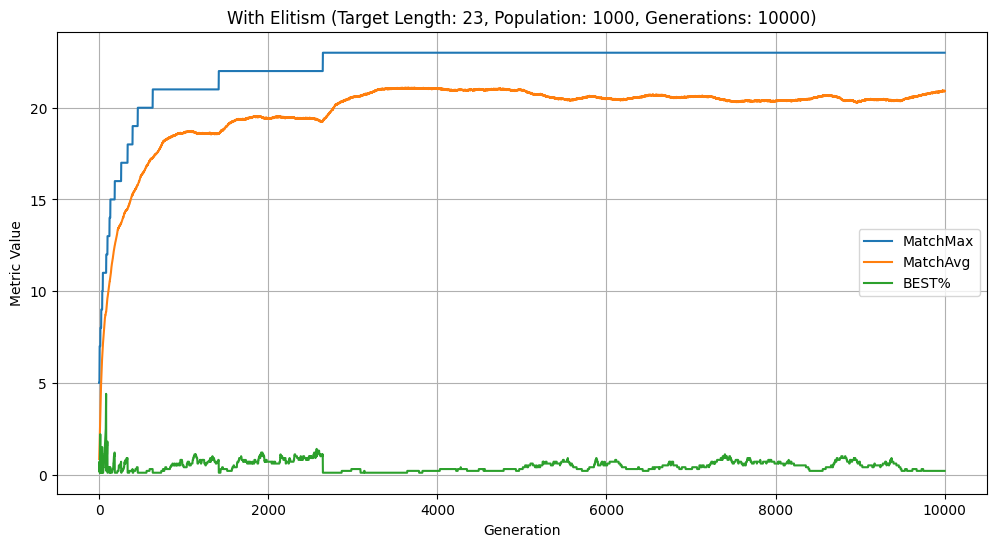

Analyzing metrics for configuration WITHOUT Elitism:


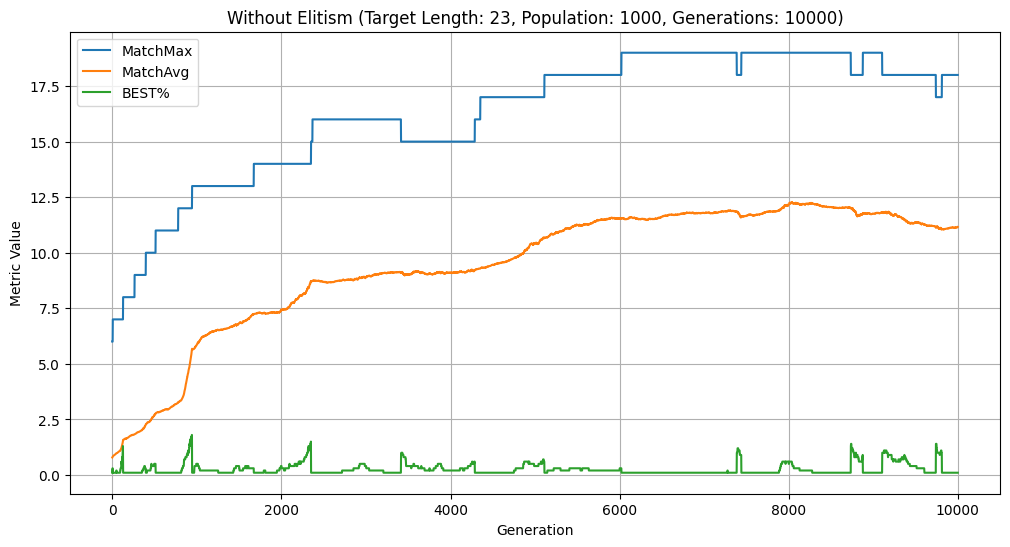


Comparison of Metrics:
With Elitism:
             Epoch         BESTf         BESTn         BEST%      MatchMax  \
count  10000.00000  1.000000e+04  10000.000000  10000.000000  10000.000000   
mean    4999.50000  7.924162e-01      4.523200      0.452320     22.311500   
std     2886.89568  3.545782e-01      2.788914      0.278891      1.842337   
min        0.00000  1.512736e-08      1.000000      0.100000      5.000000   
25%     2499.75000  3.678794e-01      2.000000      0.200000     22.000000   
50%     4999.50000  1.000000e+00      4.000000      0.400000     23.000000   
75%     7499.25000  1.000000e+00      7.000000      0.700000     23.000000   
max     9999.00000  1.000000e+00     44.000000      4.400000     23.000000   

           MatchAvg  
count  10000.000000  
mean      19.839369  
std        2.041391  
min        0.845000  
25%       19.488000  
50%       20.467000  
75%       20.687000  
max       21.094000  

Without Elitism:
             Epoch         BESTf         BE

In [ ]:
# plot metrics for both configurations
target_length = len(target)

print("Analyzing metrics for configuration WITH Elitism:")
plot_results(df_elitism, f"With Elitism (Target Length: {target_length}, Population: {population_size}, Generations: {generations})")

print("Analyzing metrics for configuration WITHOUT Elitism:")
plot_results(df_no_elitism, f"Without Elitism (Target Length: {target_length}, Population: {population_size}, Generations: {generations})")

print("\nComparison of Metrics:")
print("With Elitism:")
print(df_elitism.describe())
print("\nWithout Elitism:")
print(df_no_elitism.describe())


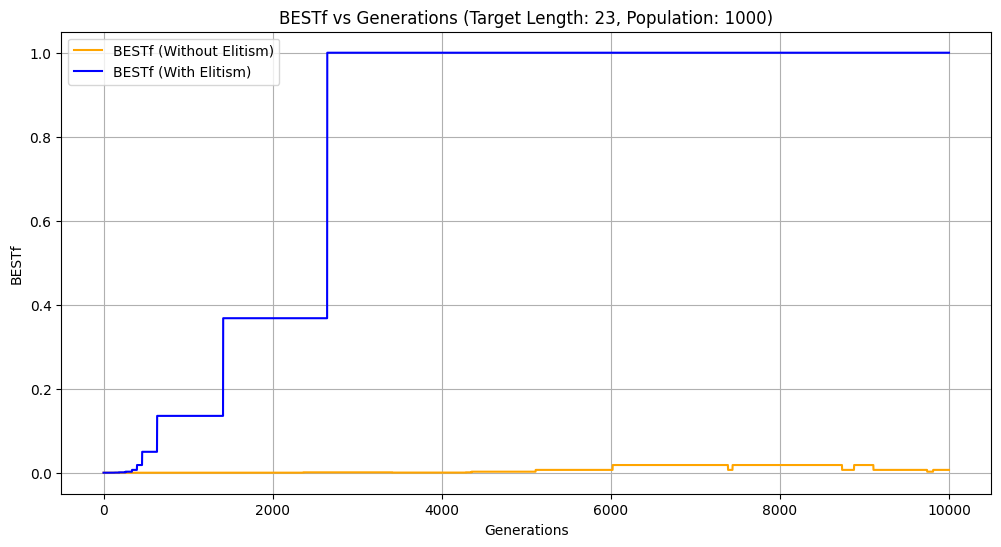

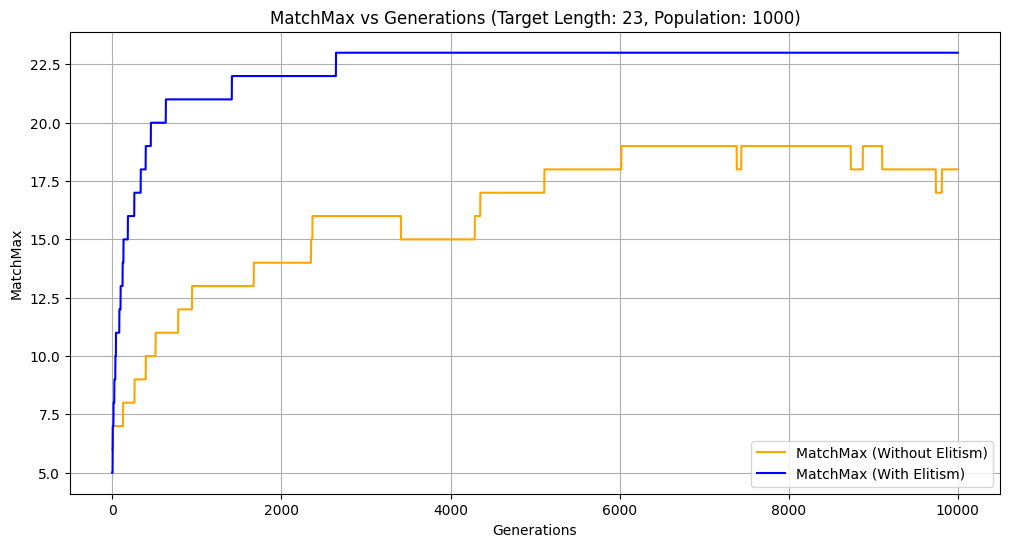

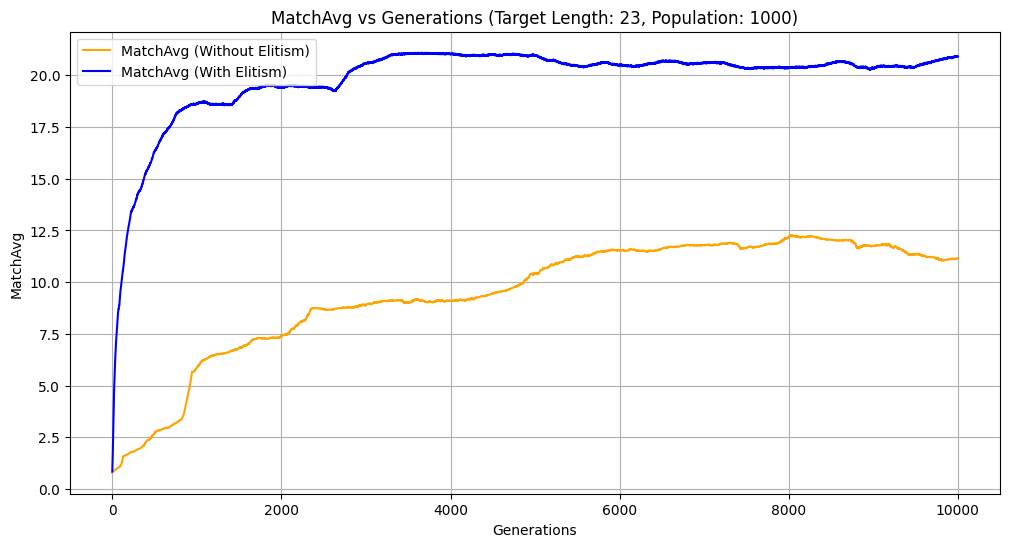

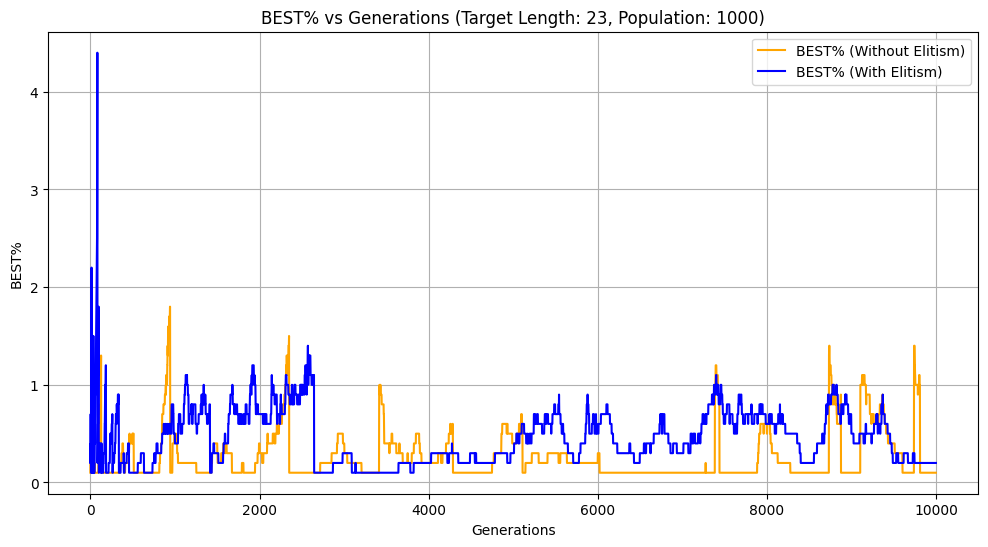

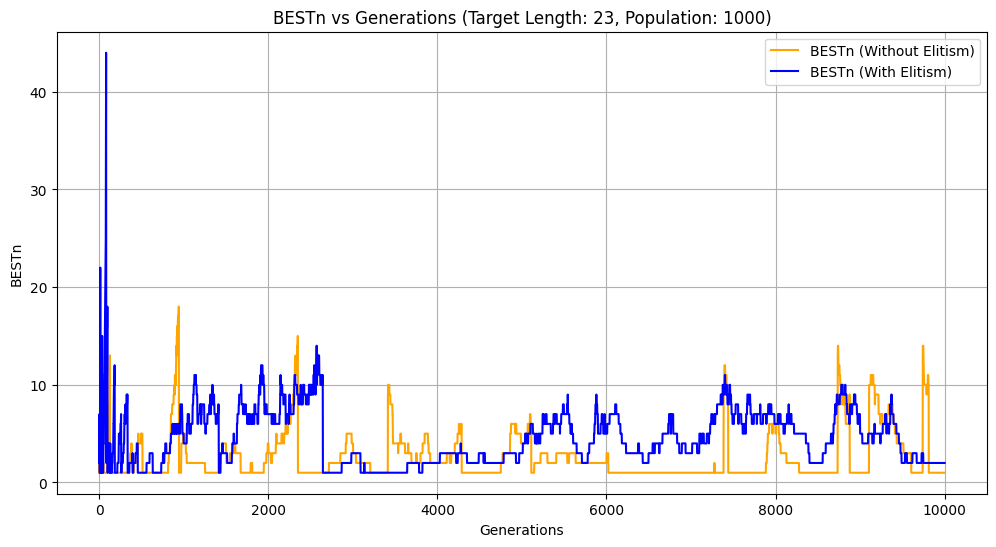

In [152]:
color_elitism = "blue"
color_no_elitism = "orange"

# Plot BESTf vs Generations
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_no_elitism, x="Epoch", y="BESTf", label="BESTf (Without Elitism)", color=color_no_elitism)
sns.lineplot(data=df_elitism, x="Epoch", y="BESTf", label="BESTf (With Elitism)", color=color_elitism)
plt.title(f"BESTf vs Generations (Target Length: {target_length}, Population: {population_size})")
plt.xlabel("Generations")
plt.ylabel("BESTf")
plt.legend()
plt.grid(True)
plt.show()

# Plot MatchMax vs Generations
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_no_elitism, x="Epoch", y="MatchMax", label="MatchMax (Without Elitism)", color=color_no_elitism)
sns.lineplot(data=df_elitism, x="Epoch", y="MatchMax", label="MatchMax (With Elitism)", color=color_elitism)
plt.title(f"MatchMax vs Generations (Target Length: {target_length}, Population: {population_size})")
plt.xlabel("Generations")
plt.ylabel("MatchMax")
plt.legend()
plt.grid(True)
plt.show()

# Plot MatchAvg vs Generations
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_no_elitism, x="Epoch", y="MatchAvg", label="MatchAvg (Without Elitism)", color=color_no_elitism)
sns.lineplot(data=df_elitism, x="Epoch", y="MatchAvg", label="MatchAvg (With Elitism)", color=color_elitism)
plt.title(f"MatchAvg vs Generations (Target Length: {target_length}, Population: {population_size})")
plt.xlabel("Generations")
plt.ylabel("MatchAvg")
plt.legend()
plt.grid(True)
plt.show()

# Plot BEST% vs Generations
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_no_elitism, x="Epoch", y="BEST%", label="BEST% (Without Elitism)", color=color_no_elitism)
sns.lineplot(data=df_elitism, x="Epoch", y="BEST%", label="BEST% (With Elitism)", color=color_elitism)
plt.title(f"BEST% vs Generations (Target Length: {target_length}, Population: {population_size})")
plt.xlabel("Generations")
plt.ylabel("BEST%")
plt.legend()
plt.grid(True)
plt.show()

# Plot BESTn vs Generations
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_no_elitism, x="Epoch", y="BESTn", label="BESTn (Without Elitism)", color=color_no_elitism)
sns.lineplot(data=df_elitism, x="Epoch", y="BESTn", label="BESTn (With Elitism)", color=color_elitism)
plt.title(f"BESTn vs Generations (Target Length: {target_length}, Population: {population_size})")
plt.xlabel("Generations")
plt.ylabel("BESTn")
plt.legend()
plt.grid(True)
plt.show()